In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

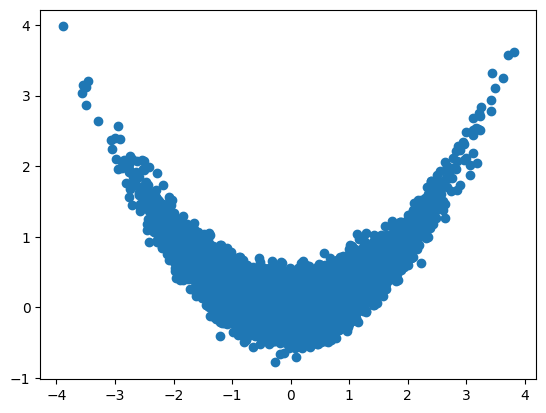

In [2]:
def sample_banana(n_samples=5000, sigma=1.0, noise=0.2):
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

# Sample data
X = sample_banana(10000)
plt.scatter(X[:,0], X[:,1])

In [3]:
class ICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims):
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims
        self.alpha = 1.0  

        self.Wx_layers = nn.ModuleList()
        self.Wz_layers = nn.ModuleList()
        self.b = nn.ParameterList()


        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            wx = nn.Linear(n_dim, hidden_dim)
            wz = nn.Linear(prev_dim, hidden_dim)

            if idx==0:
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        z = None

        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)

            if i==0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            z = F.softplus(linear_sum)

        output = self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on W^(z) weights and output layer.
        This should be called after the optimizer.step() during training.
        """
        with torch.no_grad():
            for i in range(1, len(self.Wz_layers)):
                self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))
            
            # Ensure output layer weights are also non-negative
            self.output_layer.weight.copy_(torch.abs(self.output_layer.weight))



In [20]:
base = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
S = base.sample((10000,)).cpu().numpy()
def T(xy):
    x = xy[:,0]
    y = xy[:,1]
    return np.stack([np.cbrt(x), np.cbrt(y)], axis=1)

X = T(S)
np.savez('./X_data.npz', X=X)


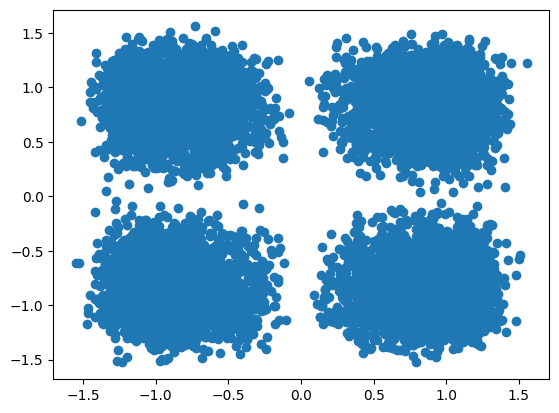

In [4]:
plt.scatter(X[:,0], X[:,1])

In [ ]:
class DeepConvexFlow(torch.nn.Module):
    """
    Deep convex potential flow parameterized by an input-convex neural network
    """

    def __init__(self, icnn, dim, n_icnns=3, unbiased=False, no_bruteforce=True, m1=10, m2=None, rtol=0.0, atol=1e-3,
                 bias_w1=0.0, trainable_w0=True):
        super(DeepConvexFlow, self).__init__()
        if m2 is None:
            m2 = dim
        
        # Create multiple ICNNs if n_icnns > 1, otherwise keep single ICNN
        if n_icnns > 1:
            self.icnn = nn.ModuleList([icnn for _ in range(n_icnns)])
            # Create separate beta parameters for each ICNN
            self.beta = nn.Parameter(torch.zeros(n_icnns) + bias_w1)
        else:
            self.icnn = icnn
            self.beta = nn.Parameter(torch.zeros(1) + bias_w1)
        
        self.n_icnns = n_icnns
        self.no_bruteforce = no_bruteforce
        self.rtol = rtol
        self.atol = atol

        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.ones(1)) - 1), requires_grad=trainable_w0)
        # Keep w1 for backward compatibility or remove if not needed
        self.w1 = torch.nn.Parameter(torch.zeros(1) + bias_w1)
        self.bias_w1 = bias_w1

        self.m1, self.m2 = m1, m2
        
    def get_potential(self, x):
        n = x.size(0)
        
        if self.n_icnns > 1:
            # Weighted sum of multiple ICNNs with individual beta weights
            icnn_weighted_sum = 0
            for i, icnn in enumerate(self.icnn):
                
                icnn_output = icnn(x)
            
                icnn_weighted_sum += F.softplus(self.beta[i]) * icnn_output
        else:
            # Single ICNN case
            
            icnn_output = self.icnn(x)
            
            icnn_weighted_sum = F.softplus(self.beta[0]) * icnn_output
        
        return icnn_weighted_sum + F.softplus(self.w0) * (x.view(n, -1) ** 2).sum(1, keepdim=True) / 2
    
    
    def reverse(self, y, max_iter=1000000, lr=1.0, tol=1e-12, x=None, **kwargs):
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            # Solves x such that f(x) - y = 0
            # <=> Solves x such that argmin_x F(x) - <x,y>
            F = self.get_potential(x)
            loss = torch.sum(F) - torch.sum(x * y)
            x.grad = torch.autograd.grad(loss, x)[0].detach()
            return loss

        optimizer = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe", max_iter=max_iter, tolerance_grad=tol,
                                      tolerance_change=tol)

        optimizer.step(closure)

        error_new = (self.forward_transform(x)[0] - y).abs().max().item()
        # if error_new > math.sqrt(tol):
        #     print('inversion error', error_new, flush=True)
        torch.cuda.empty_cache()
        gc.collect()

        return x

    def forward(self, x):
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        return f

    def forward_transform(self, x, logdet=0, extra=None):

        return self.forward_transform_bruteforce(x, logdet)

    def forward_transform_bruteforce(self, x, logdet=0):
        warnings.warn('brute force')
        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x.requires_grad_(True)
            F = self.get_potential(x)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

            # TODO: compute Hessian in block mode instead of row-by-row.
            f = f.reshape(bsz, -1)
            H = []
            for i in range(f.shape[1]):
                retain_graph = self.training or (i < (f.shape[1] - 1))
                H.append(
                    torch.autograd.grad(f[:, i].sum(), x, create_graph=self.training, retain_graph=retain_graph)[0])

            # H is (bsz, dim, dim)
            H = torch.stack(H, dim=1)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + torch.slogdet(H).logabsdet

    def extra_repr(self):
        return f"ConjGrad(rtol={self.rtol}, atol={self.atol})"


In [ ]:
icnn = ICNN(n_dim=2, hidden_dims=[4, 8, 32, 8, 4]).to(device)
model = DeepConvexFlow(icnn, 2, n_icnns=3).to(device)

#TODO: make the training step by step instead of all at once
def train(X, model, epochs=200, lr=5e-2, dim=2):
    EPOCHS = epochs
    LR=lr
    base = torch.distributions.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
    optimizer = torch.optim.NAdam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0
        for (x_batch,) in dataloader:
            x_batch = x_batch.to(device)


            y, logdet = model.forward_transform(x_batch, logdet=0.0)
            logp0 = base.log_prob(y)
            logpx = logp0 + logdet

            loss = -logpx.mean()  # NLL = reverse KL
            #l2 error
            


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if hasattr(model.icnn, '__iter__'):  # Multiple ICNNs case
                for icnn in model.icnn:
                    icnn.enforce_constraints()
            else:  # Single ICNN case
                model.icnn.enforce_constraints()



            total_loss += loss.item() * x_batch.size(0)
        
        scheduler.step()

        


        
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{EPOCHS}, NLL = {total_loss/len(X):.4f}")

train(X, model, epochs=200, lr=5e-2)

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/tmp/ipykernel_1616/2584460896.py:91: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/200, NLL = 2.6162
Epoch 10/200, NLL = 2.6187
Epoch 15/200, NLL = 2.5845
Epoch 20/200, NLL = 2.3790
Epoch 25/200, NLL = 1.6483
Epoch 30/200, NLL = 1.5614
Epoch 35/200, NLL = 1.5427
Epoch 40/200, NLL = 1.5385
Epoch 45/200, NLL = 1.5377
Epoch 50/200, NLL = 1.5304
Epoch 55/200, NLL = 1.5200
Epoch 60/200, NLL = 1.5192
Epoch 65/200, NLL = 1.5193
Epoch 70/200, NLL = 1.5170
Epoch 75/200, NLL = 1.5164
Epoch 80/200, NLL = 1.5158
Epoch 85/200, NLL = 1.5165
Epoch 90/200, NLL = 1.5150
Epoch 95/200, NLL = 1.5184
Epoch 100/200, NLL = 1.5195
Epoch 105/200, NLL = 1.5141
Epoch 110/200, NLL = 1.5132
Epoch 115/200, NLL = 1.5131
Epoch 120/200, NLL = 1.5129
Epoch 125/200, NLL = 1.5127
Epoch 130/200, NLL = 1.5127
Epoch 135/200, NLL = 1.5125
Epoch 140/200, NLL = 1.5121
Epoch 145/200, NLL = 1.5123
Epoch 150/200, NLL = 1.5130
Epoch 155/200, NLL = 1.5113
Epoch 160/200, NLL = 1.5115
Epoch 165/200, NLL = 1.5114
Epoch 170/200, NLL = 1.5114
Epoch 175/200, NLL = 1.5110
Epoch 180/200, NLL = 1.5112
Epoch 185/20

In [ ]:
import copy
import gc
import warnings
from typing import Optional, Iterable

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.func import vmap, hessian


class DeepConvexFlow(nn.Module):
    """
    Deep convex potential flow with REDUCED quadratic regularization
    """

    def __init__(
        self,
        icnn: nn.Module,
        dim: int,
        n_icnns: int = 3,
        atol: float = 1e-3,
        bias_w1: float = 0.0,
        w0_scale: float = 0.1,  # CHANGED: Much smaller quadratic weight
    ):
        super().__init__()
        self.dim = dim
        self.n_icnns = int(n_icnns)
        self.atol = atol
        self._active = n_icnns

        # ---- ICNNs and beta weights ----
        if self.n_icnns > 1:
            self.icnn = nn.ModuleList([copy.deepcopy(icnn) for _ in range(self.n_icnns)])
            self.beta = nn.ParameterList([nn.Parameter(torch.tensor(bias_w1, dtype=torch.float32))
                                          for _ in range(self.n_icnns)])
        else:
            self.icnn = icnn
            self.beta = nn.ParameterList([nn.Parameter(torch.tensor(bias_w1, dtype=torch.float32))])

        # CHANGED: Small fixed quadratic term (0.1 instead of 1.0)
        self.register_buffer('w0', torch.tensor(w0_scale))

    @torch.no_grad()
    def set_active(self, count: int):
        self._active = max(0, min(int(count), self.n_icnns))

    def get_potential(self, x: torch.Tensor) -> torch.Tensor:
        n = x.shape[0]
        # CHANGED: Smaller quadratic regularization
        quad = self.w0 * (x.reshape(n, -1).pow(2).sum(dim=1, keepdim=True) / 2.0)

        if self.n_icnns > 1:
            icnn_weighted_sum = 0.0
            n_active = getattr(self, "_active", self.n_icnns)
            for i in range(n_active):
                icnn_out = self.icnn[i](x)
                icnn_weighted_sum = icnn_weighted_sum + F.softplus(self.beta[i]) * icnn_out
        else:
            icnn_weighted_sum = F.softplus(self.beta[0]) * self.icnn(x)

        return icnn_weighted_sum + quad

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            Phi = self.get_potential(x)
            f = torch.autograd.grad(Phi.sum(), x, create_graph=True)[0]
        return f

    def reverse(self, y: torch.Tensor, max_iter: int = 100_000, lr: float = 1.0,
                tol: float = 1e-12, x: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            Fval = self.get_potential(x)
            loss = Fval.sum() - (x * y).sum()
            (grad_x,) = torch.autograd.grad(loss, (x,), retain_graph=False)
            x.grad = grad_x.detach()
            return loss

        opt = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe",
                                max_iter=max_iter, tolerance_grad=tol, tolerance_change=tol)
        opt.step(closure)

        if x.is_cuda:
            torch.cuda.empty_cache()
        gc.collect()
        return x

    def forward_transform(self, x: torch.Tensor, logdet: torch.Tensor | float = 0.0, extra=None):
        return self.forward_transform_bruteforce(x, logdet)

    def _batch_logdet_psd(self, H: torch.Tensor, jitter: float) -> torch.Tensor:
        B, D, _ = H.shape
        I = torch.eye(D, dtype=H.dtype, device=H.device).expand(B, D, D)
        Hj = H + jitter * I

        L, info = torch.linalg.cholesky_ex(Hj)
        chol_logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L, dim1=-2, dim2=-1)), dim=-1)

        sign, slog = torch.linalg.slogdet(Hj)
        ok = (info == 0) & (sign > 0)
        return torch.where(ok, chol_logdet, slog)

    def forward_transform_bruteforce(self, x: torch.Tensor, logdet: torch.Tensor | float = 0.0):
        warnings.warn("brute force", UserWarning)

        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            Phi = self.get_potential(x)
            f = torch.autograd.grad(Phi.sum(), x, create_graph=True)[0]

        x_flat = x.reshape(bsz, -1)

        def Phi_scalar_on_flat(x_row_flat: torch.Tensor) -> torch.Tensor:
            x_row = x_row_flat.reshape(1, *input_shape)
            return self.get_potential(x_row).sum()

        H = vmap(hessian(Phi_scalar_on_flat))(x_flat)
        logdet_H = self._batch_logdet_psd(H, jitter=self.atol)

        if isinstance(logdet, (int, float)):
            logdet = torch.as_tensor(logdet, dtype=logdet_H.dtype, device=logdet_H.device)
        if logdet.ndim == 0:
            logdet = logdet.expand_as(logdet_H)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + logdet_H


# -----------------------------
# Training utilities
# -----------------------------
def _set_requires_grad(params: Iterable[torch.nn.Parameter], flag: bool):
    for p in params:
        p.requires_grad_(flag)


def _enforce_icnn_constraints(model: DeepConvexFlow):
    if isinstance(model.icnn, nn.ModuleList):
        for ic in model.icnn:
            if hasattr(ic, "enforce_constraints"):
                ic.enforce_constraints()
    else:
        if hasattr(model.icnn, "enforce_constraints"):
            model.icnn.enforce_constraints()


def train_stepwise_v3(
    X,
    model: DeepConvexFlow,
    *,
    batch_size: int = 500,
    lr: float = 2e-2,  # CHANGED: Higher LR since quadratic is weaker
    per_icnn_epochs: int = 80,  # CHANGED: More epochs
    finetune_epochs: int = 150,
    print_every: int = 10,
    beta_min: float = 0.1,  # CHANGED: Higher minimum to encourage contribution
):
    """
    Training with reduced quadratic dominance
    """
    device = next(model.parameters()).device
    X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
    if X_tensor.ndim == 1:
        X_tensor = X_tensor.unsqueeze(1)

    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    flat_dim = X_tensor[0].numel()
    base = torch.distributions.MultivariateNormal(
        torch.zeros(flat_dim, device=device),
        torch.eye(flat_dim, device=device),
    )

    def make_optimizer():
        params = [p for p in model.parameters() if p.requires_grad]
        return torch.optim.AdamW(params, lr=lr, weight_decay=1e-5)  # CHANGED: AdamW with weight decay

    def run_epochs(num_epochs: int, stage_name: str, target_beta_idx: int = None):
        model.train()
        optimizer = make_optimizer()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        for epoch in range(1, num_epochs + 1):
            total_loss, total_count = 0.0, 0
            for (xb,) in loader:
                y, logdet = model.forward_transform(xb, logdet=0.0)
                logp0 = base.log_prob(y.reshape(y.shape[0], -1))
                loss = -(logp0 + logdet).mean()
                #MMD

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                optimizer.step()
                _enforce_icnn_constraints(model)

                # CHANGED: Stronger beta floor
                if target_beta_idx is not None and model.n_icnns > 1:
                    with torch.no_grad():
                        min_logit = torch.log(torch.exp(torch.tensor(beta_min, device=device)) - 1)
                        model.beta[target_beta_idx].data.clamp_(min=min_logit.item())

                total_loss += loss.item() * xb.size(0)
                total_count += xb.size(0)

            scheduler.step()
            
            if epoch % print_every == 0:
                avg_loss = total_loss / total_count
                if model.n_icnns > 1:
                    beta_vals = [F.softplus(b.data).item() for b in model.beta]
                    beta_str = ", ".join([f"β{i}={v:.3f}" for i, v in enumerate(beta_vals)])
                    print(f"[{stage_name}] Epoch {epoch:03d}/{num_epochs:03d} - NLL = {avg_loss:.6f} | {beta_str}")
                else:
                    print(f"[{stage_name}] Epoch {epoch:03d}/{num_epochs:03d} - NLL = {avg_loss:.6f}")

    order = list(range(model.n_icnns))
    
    print("=" * 80)
    print("Training with REDUCED quadratic regularization (w0=0.1)")
    print("=" * 80)

    for k in order:
        print(f"\n🎯 Training ICNN {k} (active ICNNs: [0..{k}])")
        model.set_active(k + 1)
        _set_requires_grad(model.parameters(), False)
        
        if model.n_icnns > 1:
            _set_requires_grad(model.icnn[k].parameters(), True)
            model.beta[k].requires_grad_(True)
        else:
            _set_requires_grad(model.icnn.parameters(), True)
            model.beta[0].requires_grad_(True)

        run_epochs(per_icnn_epochs, f"icnn_{k}", target_beta_idx=k)

    print("\n" + "=" * 80)
    print("Joint fine-tuning")
    print("=" * 80)
    model.set_active(model.n_icnns)
    _set_requires_grad(model.parameters(), True)
    run_epochs(finetune_epochs, "finetune")


# --------------------------------
# FIXED: Better initialization
# --------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_icnn = ICNN(n_dim=2, hidden_dims=[16, 32, 64, 32, 16]).to(device)  # CHANGED: Larger capacity

with torch.no_grad():
    base_icnn.output_layer.weight.fill_(0.1)

def create_icnn_with_noise(base_icnn, scale=0.3):  # CHANGED: More diversity
    icnn_copy = copy.deepcopy(base_icnn)
    with torch.no_grad():
        for param in icnn_copy.parameters():
            param.add_(torch.randn_like(param) * scale)
        icnn_copy.output_layer.weight.abs_()
    return icnn_copy

icnn_list = [base_icnn] + [create_icnn_with_noise(base_icnn, scale=0.3) for _ in range(2)]

# CHANGED: w0_scale=0.1 (much smaller quadratic), bias_w1=1.0 (encourage ICNN contribution)
model = DeepConvexFlow(
    icnn_list[0], 
    dim=2, 
    n_icnns=3, 
    bias_w1=1.0,  # Start with ICNNs already contributing
    w0_scale=0.1  # Reduce quadratic dominance
).to(device)

if model.n_icnns > 1:
    model.icnn = nn.ModuleList([icnn_list[i].to(device) for i in range(model.n_icnns)])

# Train with new hyperparameters
train_stepwise_v3(
    X, 
    model, 
    lr=2e-2,              # Higher LR
    per_icnn_epochs=80,   # More training per stage
    finetune_epochs=100,  # Longer fine-tuning
    print_every=10,
    beta_min=0.1,         # Higher beta floor
    batch_size=1000
)

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/tmp/ipykernel_1793/2946076325.py:109: UserWarning: brute force
  warnings.warn("brute force", UserWarning)


Training with REDUCED quadratic regularization (w0=0.1)

🎯 Training ICNN 0 (active ICNNs: [0..0])
[icnn_0] Epoch 010/080 - NLL = 2.620645 | β0=1.230, β1=1.313, β2=1.313
[icnn_0] Epoch 020/080 - NLL = 2.034657 | β0=1.200, β1=1.313, β2=1.313
[icnn_0] Epoch 030/080 - NLL = 1.834641 | β0=1.176, β1=1.313, β2=1.313
[icnn_0] Epoch 040/080 - NLL = 1.731647 | β0=1.164, β1=1.313, β2=1.313
[icnn_0] Epoch 050/080 - NLL = 1.685776 | β0=1.158, β1=1.313, β2=1.313
[icnn_0] Epoch 060/080 - NLL = 1.654673 | β0=1.158, β1=1.313, β2=1.313
[icnn_0] Epoch 070/080 - NLL = 1.643995 | β0=1.158, β1=1.313, β2=1.313
[icnn_0] Epoch 080/080 - NLL = 1.641659 | β0=1.158, β1=1.313, β2=1.313

🎯 Training ICNN 1 (active ICNNs: [0..1])
[icnn_1] Epoch 010/080 - NLL = 1.641668 | β0=1.158, β1=1.028, β2=1.313
[icnn_1] Epoch 020/080 - NLL = 1.641676 | β0=1.158, β1=1.028, β2=1.313
[icnn_1] Epoch 030/080 - NLL = 1.641670 | β0=1.158, β1=1.028, β2=1.313
[icnn_1] Epoch 040/080 - NLL = 1.641677 | β0=1.158, β1=1.028, β2=1.313
[icnn_1]

In [15]:
train_stepwise_v3(
    X, 
    model, 
    lr=2e-3,              # Higher LR
    per_icnn_epochs=5,   # More training per stage
    finetune_epochs=50,  # Longer fine-tuning
    print_every=10,
    beta_min=0.1,         # Higher beta floor
    batch_size=1000
)

Training with REDUCED quadratic regularization (w0=0.1)

🎯 Training ICNN 0 (active ICNNs: [0..0])


/tmp/ipykernel_1793/2946076325.py:109: UserWarning: brute force
  warnings.warn("brute force", UserWarning)



🎯 Training ICNN 1 (active ICNNs: [0..1])

🎯 Training ICNN 2 (active ICNNs: [0..2])

Joint fine-tuning
[finetune] Epoch 010/050 - NLL = 1.520156 | β0=0.992, β1=0.562, β2=0.567
[finetune] Epoch 020/050 - NLL = 1.519929 | β0=0.992, β1=0.555, β2=0.567
[finetune] Epoch 030/050 - NLL = 1.518801 | β0=0.992, β1=0.552, β2=0.566
[finetune] Epoch 040/050 - NLL = 1.518275 | β0=0.992, β1=0.552, β2=0.566
[finetune] Epoch 050/050 - NLL = 1.518102 | β0=0.992, β1=0.552, β2=0.566


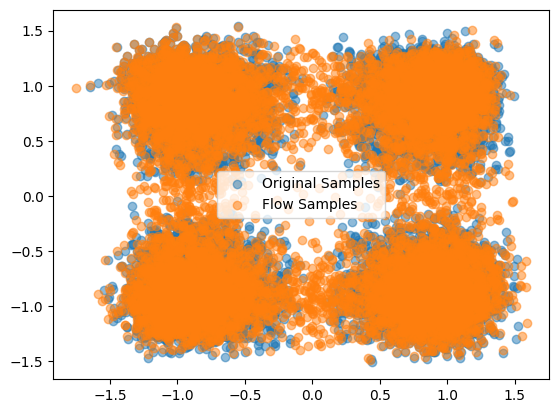

In [ ]:
S_tensor = torch.tensor(S, dtype=torch.float32, device=device)
flow_samples = model.reverse(S_tensor, max_iter=10000, lr=1.0, tol=1e-8)
flow_samples = flow_samples.cpu().detach().numpy()
plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], alpha=0.5, label='Flow Samples')
#plt.ylim(0.9, 1.1)
#plt.xlim(0.9, 1.1)
plt.legend()


In [ ]:
################################################
"""
NORMAL TRAINING:
0.04

STEPS WISE:
0.034
0.035
"""

################################################
np.mean(np.linalg.norm(flow_samples - X, axis=1))

np.float32(0.03543976)

In [21]:
np.mean(np.abs(flow_samples - X))

np.float32(0.019906977)

In [22]:
np.sqrt(0.039721925)

np.float64(0.1993036000678362)

In [8]:
g = np.linspace(-2, 2, 100)
grid = np.meshgrid(g, g)


In [9]:
x, y = grid
xy = np.stack([x.ravel(), y.ravel()], axis=1)

In [10]:
xy.shape

(10000, 2)

In [11]:
uv = T(xy)
u, v = uv[:,0], uv[:,1]

In [12]:
u.shape, v.shape

((10000,), (10000,))

In [13]:
model_samples = model.reverse(torch.Tensor(xy).to(device), max_iter=1000, lr=1.0, tol=1e-8)

/tmp/ipykernel_1616/2584460896.py:91: UserWarning: brute force
  warnings.warn('brute force')


In [14]:
u_hat, v_hat = model_samples[:,0].cpu().detach().numpy(), model_samples[:,1].cpu().detach().numpy()

In [15]:
mse = np.mean((xy[:, 0] - u_hat)**2 + (xy[:, 1] - v_hat)**2)
print("MSE between original and reconstructed grid points:", mse)

MSE between original and reconstructed grid points: 0.2704644741812784


In [16]:
mse_optimal = np.mean((xy[:,0] - u)**2 + (xy[:,1] - v)**2)
mse_optimal

np.float64(0.2606559358124673)

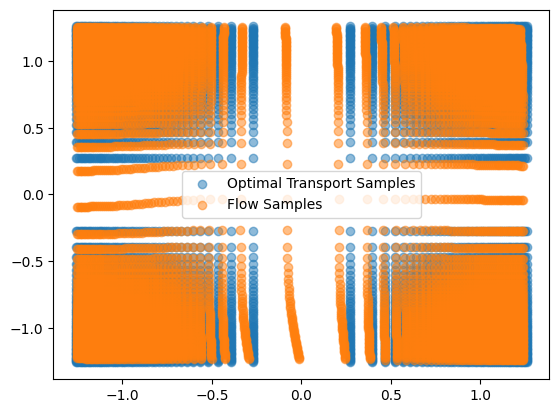

In [17]:
plt.scatter(u, v, alpha=0.5, label='Optimal Transport Samples')
plt.scatter(u_hat, v_hat, alpha=0.5, label='Flow Samples')
plt.legend()